In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers.legacy import Adam, Adamax, SGD
import os

In [ ]:
data = np.load('/kaggle/input/data-set/A01T.npz')

In [ ]:
class MotorImageryDataset:
    def __init__(self, dataset='/kaggle/input/data-set/A01T.npz'):
        if not dataset.endswith('.npz'):
            dataset += '.npz'

        self.data = np.load(dataset)

        self.Fs = 250  # 250Hz from original paper

        # keys of data ['s', 'etyp', 'epos', 'edur', 'artifacts']

        self.raw = self.data['s'].T
        self.events_type = self.data['etyp'].T
        self.events_position = self.data['epos'].T
        self.events_duration = self.data['edur'].T
        self.artifacts = self.data['artifacts'].T

        # Types of motor imagery
        self.mi_types = {769: 'left', 770: 'right',
                         771: 'foot', 772: 'tongue', 783: 'unknown'}

    def get_trials_from_channel(self, channel=7):

        # Channel default is C3

        startrial_code = 768
        starttrial_events = self.events_type == startrial_code
        idxs = [i for i, x in enumerate(starttrial_events[0]) if x]

        trials = []
        classes = []

        for index in idxs:
            try:
                type_e = self.events_type[0, index+1]
                class_e = self.mi_types[type_e]
                classes.append(class_e)

                start = self.events_position[0, index]
                stop = start + self.events_duration[0, index]
                trial = self.raw[channel, start:stop]
                trial = trial.reshape((1, -1))
                trials.append(trial)

            except:
                continue

        return trials, classes

    def get_trials_from_channels(self, channels=[7, 9, 11]):
        trials_c = []
        classes_c = []
        for c in channels:
            t, c = self.get_trials_from_channel(channel=c)

            tt = np.concatenate(t, axis=0)
            trials_c.append(tt)
            classes_c.append(c)

        return trials_c, classes_c


In [ ]:
datasetA1 = MotorImageryDataset()

In [ ]:
channels = list(range(22))

In [ ]:
trials, classes = datasetA1.get_trials_from_channels(channels=channels)

In [ ]:
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(trials[0][3])))[int(len(trials[0][3])/2):])


In [ ]:
trials = np.concatenate([trials], axis=2)

In [ ]:
fixed_trials = trials.reshape((-1, 22, 1875))
minft = fixed_trials.min()
maxft = fixed_trials.max()
fixed_trials = ((fixed_trials - minft)/(maxft - minft))

In [ ]:
fig = plt.gcf()
fig.set_size_inches(20.5, 10.5)
plt.imshow(fixed_trials[:, 0, :])

In [ ]:
left_trials, right_trials, foot_trials, tongue_trials = [],[],[],[]
for i in range(len(classes[0])):
  if classes[0][i] == "left":
    left_trials.append(fixed_trials[i])
  if classes[0][i] == "right":
    right_trials.append(fixed_trials[i])
  if classes[0][i] == "foot":
    foot_trials.append(fixed_trials[i])
  if classes[0][i] == "tongue":
    tongue_trials.append(fixed_trials[i])

In [ ]:
left_trials = np.array(left_trials)
right_trials = np.array(right_trials)
foot_trials = np.array(foot_trials)
tongue_trials = np.array(tongue_trials)

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import UpSampling2D, Conv1DTranspose, LeakyReLU, Reshape, Conv1D
from tensorflow.keras.models import Sequential, Model

In [ ]:
class GAN():
    def __init__(self):
        self.input = None
        self.num_signals = None
        self.img_rows = 22
        self.img_cols = 1875
#         self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols) # , self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(22*1875, use_bias=False ,input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Reshape((22,1875)))
        assert model.output_shape == (None, 22, 1875)  # Note: None is the batch size

        # model.add(Conv1DTranspose(64, 5, strides= 1, padding='same', use_bias=False))
        # assert model.output_shape == (None, 22, 64)
        # model.add(BatchNormalization())
        # model.add(LeakyReLU())

        model.add(Conv1DTranspose(128, 5, strides= 1, padding='same', use_bias=False))
        assert model.output_shape == (None, 22, 128)
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv1DTranspose(256,  5, strides= 1, padding='same', use_bias=False))
        assert model.output_shape == (None, 22, 256)
        model.add(BatchNormalization())
        model.add(LeakyReLU())


        model.add(Conv1DTranspose(1875, 5, strides=1, padding='same', use_bias=False, activation='tanh'))
        assert model.output_shape == (None, 22, 1875)
        model.add(Reshape(self.img_shape))

        # model.add(Dense(256, input_dim=self.latent_dim))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(Dense(512))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(Dense(1024))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        # model.add(Reshape(self.img_shape))


#         model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()



        # model.add(Conv1D(256, 5, strides=1, padding ="same", use_bias=False, input_shape=self.img_shape))
        # model.add(BatchNormalization())
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(Dropout(0.3))

        # model.add(Conv1D(126, 5, strides=1, padding ="same", use_bias=False))
        # model.add(BatchNormalization())
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(Dropout(0.3))

        # model.add(Flatten())
        # model.add(Dense(1, activation='sigmoid'))

        model.add(Flatten(input_shape=self.img_shape))

        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.3))


        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.3))

        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=100):

        X_train = self.input
        X_train = X_train*2 - 1
        # X_train = X_train / 80 - 1.
        # X_train = np.expand_dims(X_train, axis=3)

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        errors = []

        for epoch in range(epochs):


            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            gen_imgs = self.generator.predict(noise)

#             print("========= ", epoch, " =========")
#             print(imgs.shape)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            g_loss = self.combined.train_on_batch(noise, valid)

            errors.append([d_loss[0], g_loss])
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
#                 self.sample_images(epoch)

        plt.plot(errors)
        plt.xlabel('Epochs')
        plt.grid()
    def sample_images(self, epoch):
        print('sample!')

        num_signals = self.num_signals
        noise = np.random.normal(0, 1, (num_signals, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs= plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
        fig.set_size_inches(20.5, 10.5)

        axs.imshow(gen_imgs[:,0,:])

        fig.savefig("/content/drive/MyDrive/GAN/samples/%d.png" % epoch)
        plt.close()


In [ ]:
gan_left = GAN()
gan_left.input = left_trials
gan_left.num_signals = 273
gan_left.train(2000, batch_size=10)

In [ ]:
gan_right = GAN()
gan_right.input = right_trials
gan_right.num_signals = 273
gan_right.train(2000, batch_size=10)

In [2]:
gan_foot = GAN()
gan_foot.input = foot_trials
gan_foot.num_signals = 273
gan_foot.train(2000, batch_size=10)

NameError: name 'GAN' is not defined

In [ ]:
gan_tongue = GAN()
gan_tongue.input = tongue_trials
gan_tongue.num_signals = 273
gan_tongue.train(2000, batch_size=10)

In [ ]:
num_signals = gan_left.num_signals
noise = np.random.normal(0, 1, (num_signals, gan_left.latent_dim))
gen_imgs = gan_left.generator.predict(noise)

In [ ]:
fig = plt.gcf()
fig.set_size_inches(20.5, 10.5)
plt.imshow(gen_imgs[:, 0, :])

In [ ]:
fake_signal = []

In [ ]:
gan_left.num_signals=1
gan_right.num_signals=1
gan_foot.num_signals=1
gan_tongue.num_signals=1

In [ ]:
for i in range(len(classes[0])):
    num_signals = gan_left.num_signals
    noise = np.random.normal(0, 1, (num_signals, gan_left.latent_dim))
    if classes[0][i] == "left":
        gen_imgs = gan_left.generator.predict(noise)
    if classes[0][i] == "right":
        gen_imgs = gan_right.generator.predict(noise)
    if classes[0][i] == "foot":
        gen_imgs = gan_foot.generator.predict(noise)
    if classes[0][i] == "tongue":
        gen_imgs = gan_tongue.generator.predict(noise)
    fake_signal.append(gen_imgs)

In [ ]:
fake_signal = np.concatenate(fake_signal, axis=0)

In [ ]:
fake_signal = np.array(fake_signal)

In [1]:
fake_signal.shape

NameError: name 'fake_signal' is not defined

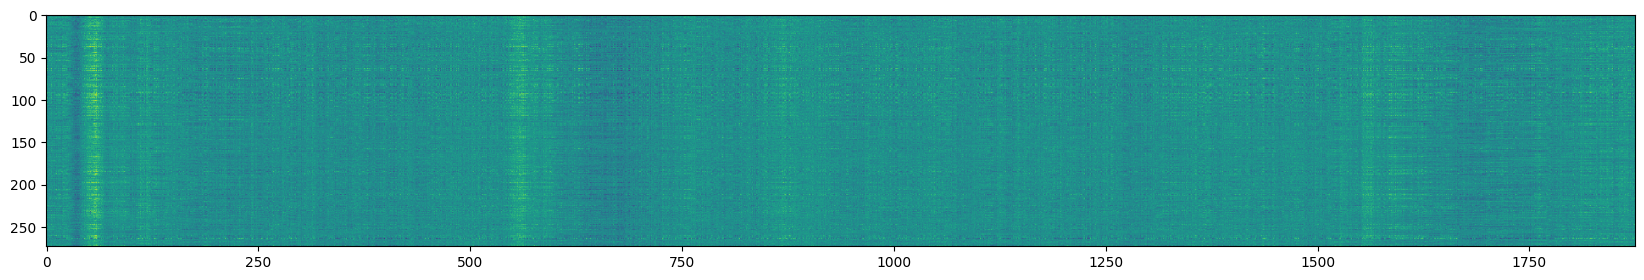

In [118]:
fig = plt.gcf()
fig.set_size_inches(20.5, 10.5)
plt.imshow(fake_signal[:, 0, :])